In [4]:
pip install larq

Note: you may need to restart the kernel to use updated packages.


In [4]:
from numpy import mean
from numpy import std
from tensorflow import keras
from sklearn.model_selection import KFold
from keras.datasets import mnist
#from keras.utils import to_categorical
from matplotlib import pyplot as plt
import tensorflow as tf
import larq as lq

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [6]:
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip",
              use_bias=False)

In [7]:
def load_dataset():
    # load dataset
    (trainX, trainY), (testX, testY) = mnist.load_data()
    # reshape dataset to have a single channel
    trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
    testX = testX.reshape((testX.shape[0], 28, 28, 1))
    # one hot encode target values
    trainY = tf.keras.utils.to_categorical(trainY)
    testY = tf.keras.utils.to_categorical(testY)
    return trainX, trainY, testX, testY

In [8]:
# scale pixels
def prep_pixels(train, test):
    # convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
    # normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
    # return normalized images
    return train_norm, test_norm

In [9]:
def define_model():
    model = tf.keras.models.Sequential([
        lq.layers.QuantConv2D(128, 3,
                              kernel_quantizer="ste_sign",
                              kernel_constraint="weight_clip",
                              use_bias=False,
                              input_shape=(28, 28, 1)),
        tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

        lq.layers.QuantConv2D(128, 3, padding="same", **kwargs),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

        lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
        tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

        lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

        lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
        tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

        lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
        tf.keras.layers.Flatten(),

        lq.layers.QuantDense(1024, **kwargs),
        tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

        lq.layers.QuantDense(1024, **kwargs),
        tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

        lq.layers.QuantDense(10, **kwargs),
        tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
        tf.keras.layers.Activation("softmax")
    ])
    opt = keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-6)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [10]:
def evaluate_model(dataX, dataY, n_folds=5):
    scores, histories = list(), list()
    # prepare cross validation
    kfold = KFold(n_folds, shuffle=True, random_state=1)
    # enumerate splits
    for train_ix, test_ix in kfold.split(dataX):
        # define model
        model = define_model1()
        # select rows for train and test
        trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
        # fit model
        history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose='auto')
        # evaluate model
        _, acc = model.evaluate(testX, testY, verbose='auto')
        print('> %.3f' % (acc * 100.0))
        # stores scores
        scores.append(acc)
        histories.append(history)
    return scores, histories

In [11]:
def summarize_diagnostics(histories):
    for i in range(len(histories)):
        # plot loss
        plt.subplot(2, 1, 1)
        plt.title('Cross Entropy Loss')
        plt.plot(histories[i].history['loss'], color='blue', label='train')
        plt.plot(histories[i].history['val_loss'], color='orange', label='test')
        # plot accuracy
        plt.subplot(2, 1, 2)
        plt.title('Classification Accuracy')
        plt.plot(histories[i].history['accuracy'], color='blue', label='train')
        plt.plot(histories[i].history['val_accuracy'], color='orange', label='test')
    plt.show()

In [12]:
def summarize_performance(scores):
    # print summary
    print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores) * 100, std(scores) * 100, len(scores)))
    # box and whisker plots of results
    plt.boxplot(scores)
    plt.show()


In [37]:
def define_model1():
    model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(),
    lq.layers.QuantDense(128,
                        kernel_quantizer="ste_sign",
                        kernel_constraint="weight_clip",
                        use_bias=False,
                        input_shape=(784,)),
        
        lq.layers.QuantDense(1024, **kwargs),
        #tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

        lq.layers.QuantDense(1024, **kwargs),
        #tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

        lq.layers.QuantDense(10, **kwargs),
        #tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
        tf.keras.layers.Activation("softmax")
    ])
    opt = keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-6)
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [14]:
# run the test harness for evaluating a model
def run_test_harness():
    # load dataset
    trainX, trainY, testX, testY = load_dataset()
    # prepare pixel data
    trainX, testX = prep_pixels(trainX, testX)
    # evaluate model
    scores, histories = evaluate_model(trainX, trainY)
    # learning curves
    summarize_diagnostics(histories)
    # summarize estimated performance
    summarize_performance(scores)

In [27]:
# entry point, run the test harness
#run_test_harness()
# load dataset
trainX, trainY, testX, testY = load_dataset()
# prepare pixel data
trainX, testX = prep_pixels(trainX, testX)
trainX = trainX[0:10000,:,:]
trainY = trainY[0:10000,:]
# evaluate model
#scores, histories = evaluate_model(trainX, trainY)
# learning curves
#summarize_diagnostics(histories)
# summarize estimated performance
#summarize_performance(scores)

In [16]:
trainX.shape

(10000, 28, 28, 1)

In [17]:
trainY.shape

(10000, 10)

In [38]:
scores, histories = evaluate_model(trainX, trainY)

Epoch 1/10
250/250 [==============================] - 3s 11ms/step - loss: 26.7511 - accuracy: 0.3204 - val_loss: 16.4845 - val_accuracy: 0.4775
Epoch 2/10
250/250 [==============================] - 3s 11ms/step - loss: 14.4714 - accuracy: 0.5386 - val_loss: 12.7931 - val_accuracy: 0.5900
Epoch 3/10
250/250 [==============================] - 3s 11ms/step - loss: 12.0531 - accuracy: 0.5962 - val_loss: 11.1892 - val_accuracy: 0.6230
Epoch 4/10
250/250 [==============================] - 3s 11ms/step - loss: 10.3583 - accuracy: 0.6478 - val_loss: 10.2021 - val_accuracy: 0.6485
Epoch 5/10
250/250 [==============================] - 3s 11ms/step - loss: 9.4192 - accuracy: 0.6659 - val_loss: 9.3186 - val_accuracy: 0.6685
Epoch 6/10
250/250 [==============================] - 3s 11ms/step - loss: 8.7796 - accuracy: 0.6786 - val_loss: 8.1700 - val_accuracy: 0.6955
Epoch 7/10
250/250 [==============================] - 3s 11ms/step - loss: 8.5550 - accuracy: 0.6826 - val_loss: 8.2681 - val_accuracy

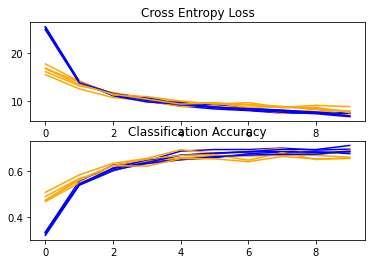

In [35]:
summarize_diagnostics(histories)

Accuracy: mean=66.930 std=1.489, n=5


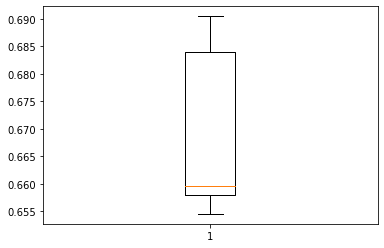

In [36]:
summarize_performance(scores)

In [ ]:
model.summery()